In [ ]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

In [ ]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

# Dufour et al. 2014 chemotaxis model


In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        :isSource => Bool,
        :S => Float64,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64 #CheYP levels, probability of tumbling

    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        # :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :A0 => Float64,
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP
        :λ0 => Float64,    #Tumbling rate - CW bias
        :g => Float64      #Motor gain
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        L = max(mm, 1e-12)  #Concentration, avoid log(0)
        F = ε0 + ε1 * methyl + Nrec * log((1 + L / Ki) / (1 + L / Ka)) #Equació del paper per definir activitat del receptor
        

        A = 1 / (1 + exp(F)) #Receptor activity
        dt(methyl) = (A0 - A) / τm   #Adaptation
        Yp = Yp0 + α * (A - A0)  #CheYP activity depenent on adaptation
        
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω

    end,

    agentRule = quote

        if isSource
            σ = sqrt(2 * DSource / dt)

            vx = σ * randn()
            vy = σ * randn()
            ω = 0.0

            mm += S
        end

        if tTumble < t && active        #Is running, will change to tumble for 1 second
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0              #Paper treballa amb dos rates (tumble and run), afegir aqui??
        elseif tTumble < t && !active       #Time over?
            ω = 0.0                         #Stop tumbling
            active = true                   #Run active
            # λ = λ0 * (Yp /Yp0)  
            ΔY = Yp - Yp0
            λ = λ0 * exp(g * ΔY)            #Tumbling probability
            λ = clamp(λ, 0.05, 20.0)      
            tTumble += CBMDistributions.exponential(1/λ)   #Large lambda = shorter time = more switching; small lambda = longer time = run 
            #Large lambda = short run time = when unfavourable environment = less mm = less Rc activity = more Yp = more tumbling
            #Small lambda = long run time = when favourable environment = more mm = more Rc activity = less Yp = longer run 
            #More Yp = large lambda
            #Less Yp = smaller lambda
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

In [ ]:
com = Community(
    rods2DChemotaxis,
    N=2,
    dt=0.1,
    simBox=[-20 20;-20 20.],  #change box
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 0.0
# com.τTumble = 2
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.A0 = 0.5
com.τm = 10.0
com.α   = 6.0
com.Yp0 = 3.0   
com.λ0 = 1.0
com.g = 3.0

com.ωTumble = 1
com.DMedium = 0.00
com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)
com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

src = 1

# com.active[src] = false 
com.isSource .= false
# com.isSource[src] = true

com.S = 0.0
# com.S[src] = 2.0

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

for i in 1:Nx, j in 1:Ny
    com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
end


In [ ]:
using CSV, DataFrames

outfile = "trajectory.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    mm = Float64[],
    Yp = Float64[]
)

CSV.write(outfile, data)

steps = 1000
loadToPlatform!(com, preallocateAgents=2)       #Preallocate agents = number of agents in community

for step in 1:steps
    step!(com)
    if step % saveEvery == 0
        data = DataFrame(
            step = fill(step, com.N),
            id = collect(1:com.N),
            x = copy(com.x),
            y = copy(com.y),
            mm = copy(com.mm),
            Yp = copy(com.Yp)
        )
    
end


In [ ]:
evolve!(com, steps = 1000, saveEach = 100)

In [ ]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

In [ ]:
d = getParameter(com,[:x])

fig = Figure(size=(400,400))

ax = Axis(fig[1,1],xlabel="time",ylabel="mean(x)",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )
lines!(ax,[i.t for i in com.pastTimes],[mean(i) for i in d[:x]])

display(fig)

In [14]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        # :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        # :tTumble => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64 #CheYP levels, probability of tumbling
    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        # :βω => Float64,
        # :ωTumble => Float64,
        # :fChem => Float64
        :DMedium => Float64,
        # :DSource => Float64,
        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP 
        :ωFrec => Float64,       #Basal switching frequency
        :mm => Float64
    ),

    # medium = Dict(
    #     :mm => Float64
    # ),

    agentODE = quote

        mm = 0.02*exp((x - com.simBox[1,1])*3*30^(-3 ))
      
        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(α / Yp0 - 1  )         #Energia lliure en estat adaptat

        dt(methyl) = -(F - F0) / (ε1 * τm)          #Methylation
        Yp = α / (1 + exp(F))                       #CheYp segons activitat receptor
        
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        # dt(x) = (active * vx  + fx) / β      #Change position acording to constant speed afected by forces
        # dt(y) = (active * vy  + fy) / β
        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
    end,

    agentRule = quote

        if active 
            G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))
            λrt = ωFrec*exp(-G)*dt 
            P_rt = 1 - exp(-λrt * dt)
            P = rand()
            if P < λrt      #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            # if P < P_rt      #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
            else    #Si rate baixa 
            # elseif P > P_rt      #Si rate baixa 
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
            end

        elseif !active
            G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()
            # if P < P_tr
            if P < λtr
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()
            # elseif P > P_tr
            else
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))
            end
            
        end

 
        if x < simBox[1,1]
            x = simBox[1,1]
            theta = pi - theta      #Avoid stuck in wall
        elseif x > simBox[1,2]
            x = simBox[1,2]
            theta = pi - theta
        end
        if y < simBox[2,1]
            y = simBox[2,1]
            theta = -theta
        elseif y > simBox[2,2]
            y = simBox[2,2]
            theta = -theta
        end
    end,

    # mediumODE = quote
    #     if @mediumInside()
    #         dt(mm) = exp((i1_)/NMedium[2])/exp(1)
    #     end
    # end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	d (Float64 agent)
	active (Bool agent)
	v (Float64 agent)
	fx (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	γn (Float64 model)
	Dr_run (Float64 model)
	μcw (Float64 model)
	Ka (Float64 model)
	mm (Float64 model)
	ε3 (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	ε0 (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	Yp0 (Float64 model)
	τm (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)


UPDATE RULES
agentRule
 begin
    if active
        G = ε2 / 4 - (ε3 / 2) / (1 + K / Yp)
        λrt = ωFrec * exp(-G) * dt
        P_rt = 1 - exp(-λrt * dt)
        P = rand()
        if P < λrt
            active__ = false
 

In [36]:
com = Community(
    rods2DChemotaxis,
    N=20,
    dt=0.1,
    simBox=[-2000 2000;-2000 2000.],  #change box
    NMedium=[20000,20000],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = 0.8
# com.βω = 0.8
# com.fChem = 1.0
com.Dr_run = 0.062

com.v = 20.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
com.τm = 30.0
com.α   = 6.0
com.Yp0 = 3.0  
com.K = 3.0 

# com.ωTumble = 1
com.DMedium = 0.00
# com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

# for i in 1:Nx, j in 1:Ny
#     # com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
#     com.mm[i, j] =  0.02*exp((xvals[i] - com.simBox[1,1])*3*30^(-3 ))
# end

-2000.0:0.20001000050002501:2000.0

In [37]:
using CSV, DataFrames

outfile = "trajectory.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    Yp = Float64[]
)



steps = 1000
loadToPlatform!(com, preallocateAgents=20)       #Preallocate agents = number of agents in community


for step in 1:steps
    step!(com)
    for i in 1:com.N
        push!(data, (
            step, 
            i,
            com.x[i],
            com.y[i],
            com.Yp[i]
        ))
    end
end

CSV.write(outfile, data)

"trajectory.csv"

In [57]:
groupby(data, :id)

Row,step,id,x,y,Yp
,Int64,Int64,Float64,Float64,Float64
1,1,1,376.332,-844.061,0.0148357
2,2,1,374.391,-843.579,0.000138672
3,3,1,372.424,-843.221,0.000143696
4,4,1,370.424,-843.208,0.000148779
5,5,1,368.426,-843.295,0.000154029
6,6,1,366.429,-843.182,0.000159445
7,7,1,364.488,-842.697,0.000165027
8,8,1,362.558,-842.173,0.000170791
9,9,1,360.734,-841.352,0.000176734


In [62]:
gr_data = groupby(data, :id)
cell1 = gr_data[1]

Row,step,id,x,y,Yp
,Int64,Int64,Float64,Float64,Float64
1,1,1,376.332,-844.061,0.0148357
2,2,1,374.391,-843.579,0.000138672
3,3,1,372.424,-843.221,0.000143696
4,4,1,370.424,-843.208,0.000148779
5,5,1,368.426,-843.295,0.000154029
6,6,1,366.429,-843.182,0.000159445
7,7,1,364.488,-842.697,0.000165027
8,8,1,362.558,-842.173,0.000170791
9,9,1,360.734,-841.352,0.000176734


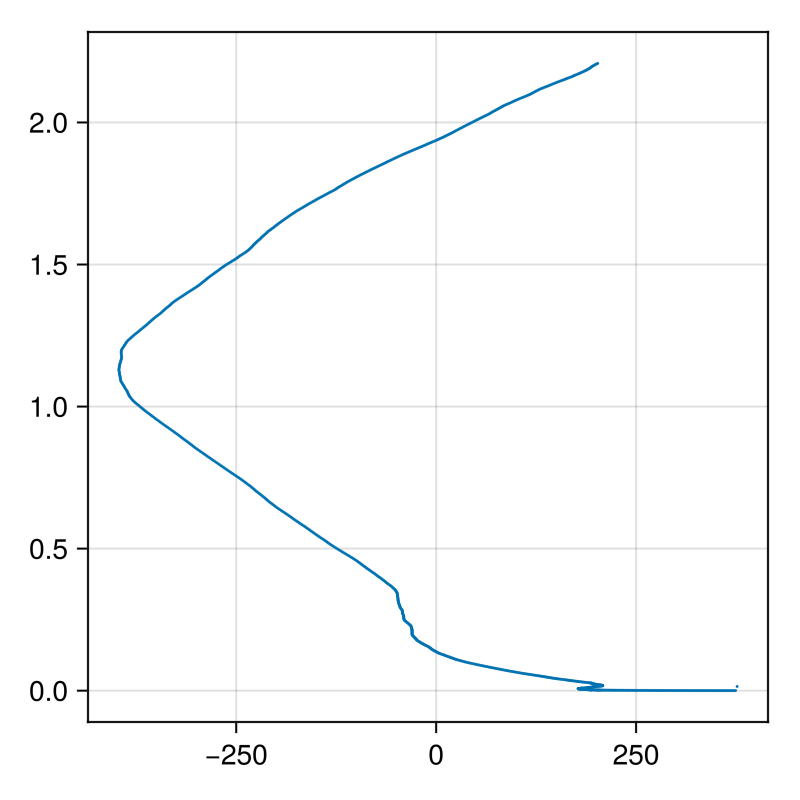

GLMakie.Screen(...)

In [ ]:
#Plot Yp

fig = Figure(size=(400,400))

ax = Axis(fig[1,1])
scatter!(ax, cell1[!, :x], cell1[!, :Yp], markersize= 2)

display(fig)





In [16]:
evolve!(com, steps = 10000, saveEach = 1000)

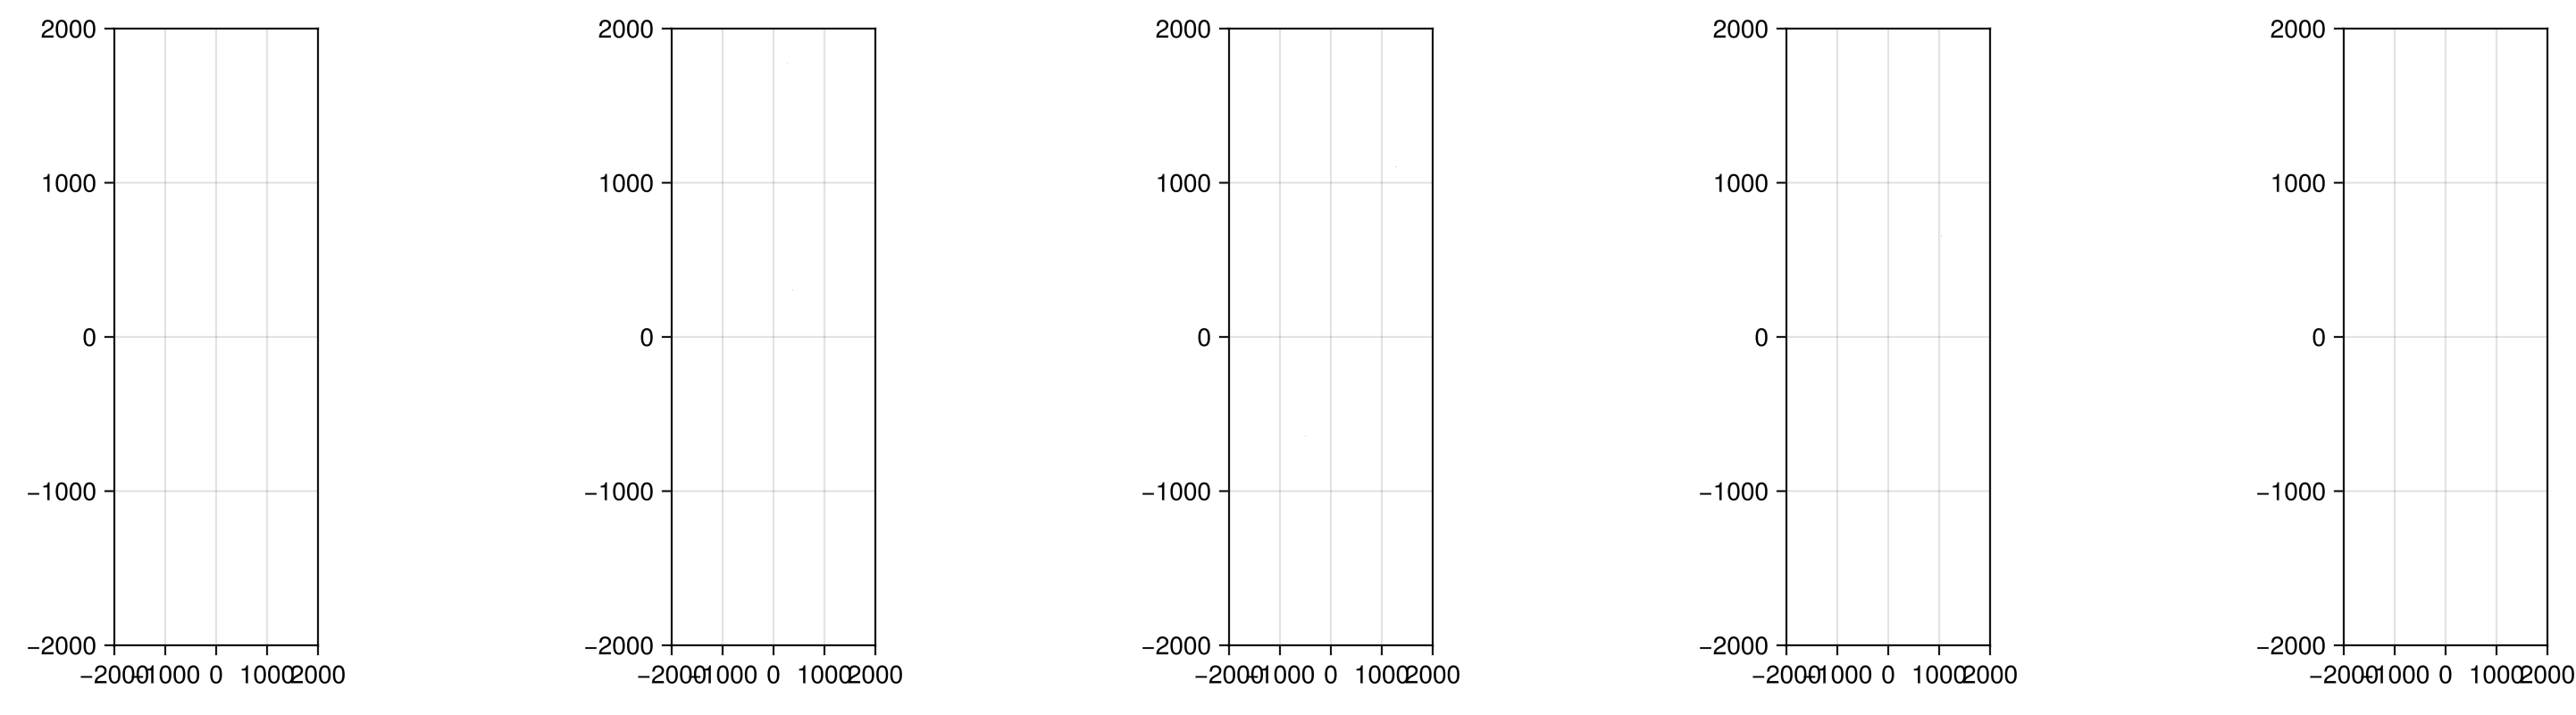

GLMakie.Screen(...)

In [13]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm])

        ax = Axis(fig[1,2*j-1])

        # m = heatmap!(ax,
        #         range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
        #         range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
        #         d[:mm][i],
        #         # colorrange=(0,2.)
        # )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)


        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        # Colorbar(fig[1,2*j],m)


    end
end

display(fig)